In [59]:
import sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.model_selection import RepeatedStratifiedKFold

from imblearn.pipeline import Pipeline

import xgboost as xgb

import pandas as pd

In [60]:
flights_weather_df = pd.read_csv('../data/intermediate/modelling/flights_weather_modelling.csv')
flights_weather_df = flights_weather_df.astype(float)

In [61]:
X = flights_weather_df.drop(columns=['INDEX', 'IS_WEATHER_DELAY'])
y = flights_weather_df["IS_WEATHER_DELAY"]

In [ ]:
k_folds = 10
rs = 0

Decision Trees

In [76]:
best_params = []

params = {
    'classifier__max_depth': [2, 4, 6, 8, 10, 20, 30, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

# insure no information leaking between train and validation sets by using pipeline
pipeline = Pipeline([
    ('scaler', MinMaxScaler(feature_range=(-1, 1))),  # normalization
    ('classifier', DecisionTreeClassifier(criterion='entropy'))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

cv_struct = RepeatedStratifiedKFold(n_splits = k_folds, n_repeats=1, random_state=rs)

dt_grid_search = GridSearchCV(pipeline, param_grid=params, cv=k_folds)
dt_grid_search.fit(X_train, y_train)

# get the best models 
dt_best = dt_grid_search.best_estimator_
print("Pre-pruned Decision Tree Best Params: " + str(dt_grid_search.best_params_))
    
# evaluate the model
# make predictions on the testing data
df_y_pred = dt_best.predict(X_test)

# calculate the accuracy of the model
accuracy = accuracy_score(y_test, df_y_pred)
print("Accuracy of Pre-pruned Decision Tree: ", accuracy)

Pre-pruned Decision Tree Best Params: {'classifier__max_depth': 8, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 10}
Accuracy of Pre-pruned Decision Tree:  0.6253602305475504


In [89]:
cm = confusion_matrix(y_test, y_pred)
# Display the confusion matrix
df_cm = pd.DataFrame(cm, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])
print(df_cm)

          Predicted 0  Predicted 1
Actual 0         1074          403
Actual 1          592          707


Random Forests

In [86]:
# only need 2 folds as random forests already gets an unbiased estimate
k_folds = 5

params = {
    'classifier__n_estimators': [100, 200],  # Number of trees in the forest
    'classifier__max_depth': [None, 5, 10],  # Maximum depth of each tree
    'classifier__min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
    'classifier__min_samples_leaf': [1, 2, 4]  # Minimum number of samples required to be at a leaf node
}


pipeline = Pipeline([
    ('scaler', MinMaxScaler(feature_range=(-1, 1))), # normalization
    ('classifier', RandomForestClassifier())
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# Perform grid search for hyperparameter tuning with proper cross-validation
rf_grid_search = GridSearchCV(pipeline, param_grid=params, cv=k_folds)
rf_grid_search.fit(X_train, y_train)

# Get the best estimator (model)
rf_best = rf_grid_search.best_estimator_
print("Random Forest Best Params:", rf_grid_search.best_params_)

# Evaluate the model
y_pred = rf_best.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of Random Forest:", accuracy)
print("Accuracy: {:.2f}%".format(accuracy * 100))

Random Forest Best Params: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}
Accuracy of Random Forest: 0.6415706051873199
Accuracy: 64.16%


In [88]:
cm = confusion_matrix(y_test, y_pred)
# Display the confusion matrix
rf_cm = pd.DataFrame(cm, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])
print(rf_cm)

          Predicted 0  Predicted 1
Actual 0         1074          403
Actual 1          592          707


Adaboost

In [45]:
k_folds = 5

params = {
    'classifier__n_estimators': [100, 200, 300],  # Number of estimators (trees)
    'classifier__learning_rate': [0.1, 0.5, 1.0],  # Learning rate
    'classifier__base_estimator__max_depth': [1, 2, 5],  # Maximum depth of each base estimator (decision tree)
    'classifier__base_estimator__min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
    'classifier__base_estimator__min_samples_leaf': [1, 2, 4]  # Minimum number of samples required to be at a leaf node
}

pipeline = Pipeline([
    ('scaler', MinMaxScaler(feature_range=(-1, 1))), # normalization
    ('classifier', AdaBoostClassifier(base_estimator=DecisionTreeClassifier()))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rs)

# Perform grid search for hyperparameter tuning with proper cross-validation
adaboost_grid_search = GridSearchCV(pipeline, param_grid=params, cv=k_folds)
adaboost_grid_search.fit(X_train, y_train)

# Get the best estimator (model)
adaboost_best = adaboost_grid_search.best_estimator_
print("AdaBoost Best Params:", adaboost_grid_search.best_params_)

# Evaluate the model
y_pred = adaboost_best.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of AdaBoost:", accuracy)

Accuracy: 63.40%


In [46]:
cm = confusion_matrix(y_test, y_pred)
# Display the confusion matrix
ada_cm = pd.DataFrame(cm, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])
print(df_cm)

          Predicted 0  Predicted 1
Actual 0         1016          433
Actual 1          583          744


XGBoost

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

# Define the XGBoost classifier
xgb_clf = xgb.XGBClassifier(random_state=100)

# Define the hyperparameters and their ranges to search
params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5]
}

# Create a grid search object with cross-validation
grid_search = GridSearchCV(xgb_clf, params, cv=5, scoring='roc_auc', n_jobs=-1)

# Fit the grid search object to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and their corresponding score
print("Best parameters: ", grid_search.best_params_)
print("Best score: {:.2f}%".format(grid_search.best_score_*100))

best_model = grid_search.best_estimator_

# Predict the labels of the test data using the best XGBoost classifier
y_pred = best_model.predict(X_test)

# Evaluate the performance of the best XGBoost classifier using accuracy and ROC AUC score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy*100))

Best parameters:  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Best score: 68.84%
Accuracy: 64.99%


In [48]:
cm = confusion_matrix(y_test, y_pred)
# Display the confusion matrix
xgboost_cm = pd.DataFrame(cm, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])
print(df_cm)

          Predicted 0  Predicted 1
Actual 0         1087          382
Actual 1          590          717


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

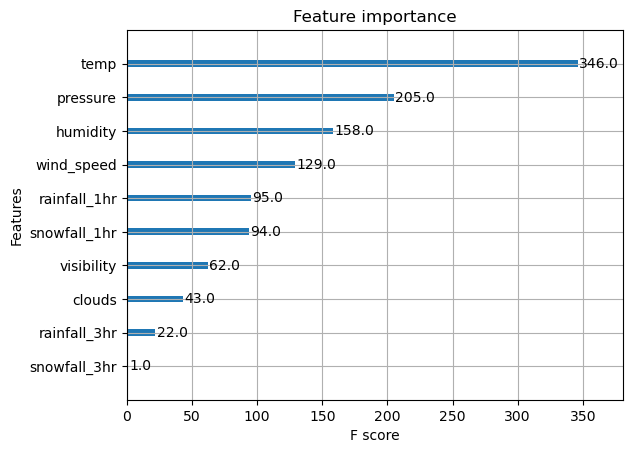

In [49]:
xgb.plot_importance(best_model)